### Install Packages


In [ ]:
!pip install tensorflow==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import json
import zipfile

In [ ]:
print(tf.__version__)

2.16.1


### Load Data dan Preprocessing

In [ ]:
from google.colab import drive
# Menghubungkan ke Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the dataset directory
dataset_dir = '/content/drive/MyDrive/Coconut Tree Disease Dataset2'
class_folders = ["Bud Root Dropping", "Bud Rot", "Gray Leaf Spot", "Leaf Rot", "Stem Bleeding"]

In [ ]:
def image_transform(image):
    # Resize the image to 256x256
    resized_image = tf.image.resize(image, [256, 256])
    # Convert the image to float32 tensor
    tensor_image = tf.image.convert_image_dtype(resized_image, tf.float32)
    return tensor_image


In [ ]:
def is_valid_image(file_path):
    try:
        # Membaca file gambar menggunakan TensorFlow
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)  # Menentukan jumlah saluran (channels)
        return True
    except tf.errors.InvalidArgumentError:  # Menggunakan exception dari TensorFlow untuk gambar yang tidak valid
        return False

In [ ]:
#Preprocessing
# Membuat generator data untuk memuat dan melakukan transformasi data
datagen = ImageDataGenerator(
    preprocessing_function=image_transform,  # Transformasi gambar
    validation_split=0.2  # Split data menjadi data latih dan data validasi
)

# Memuat dataset dari direktori
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 1600 images belonging to 5 classes.
Found 400 images belonging to 5 classes.


In [ ]:
# Mengambil kelas-kelas yang valid (tidak sama dengan 'drive')
valid_classes = [cls for cls in train_generator.class_indices.keys() if cls != 'drive']

# Membuat kamus yang memetakan kelas ke indeks
valid_class_to_idx = {cls: idx for idx, cls in enumerate(valid_classes)}


In [ ]:
# Membuat kamus kelas ke indeks
valid_class_to_idx = {cls: idx for idx, cls in enumerate(valid_classes)}
train_generator.class_indices = valid_class_to_idx

# Menampilkan item-item pada atribut class_to_idx
print(train_generator.class_indices.items())


dict_items([('Bud Root Dropping', 0), ('Bud Rot', 1), ('Gray Leaf Spot', 2), ('Leaf Rot', 3), ('Stem Bleeding', 4)])


### Visualisasi

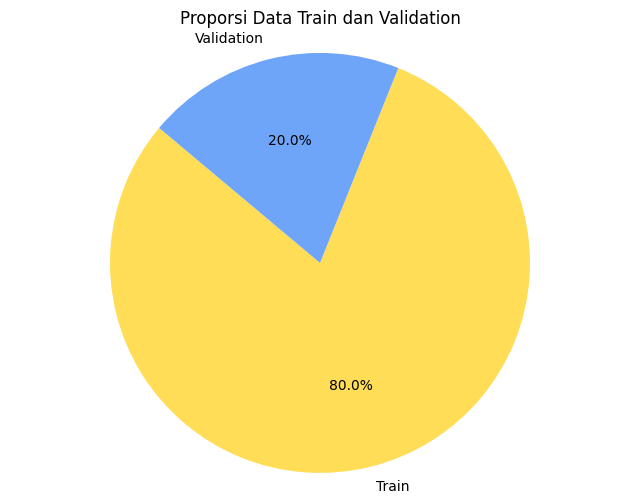

In [ ]:
train_total = train_generator.samples
val_total = val_generator.samples
# Menghitung jumlah data train dan val
total_train_samples = train_total
total_val_samples = val_total

# Membuat visualisasi
plt.figure(figsize=(8, 6))

# Visualisasi jumlah data train dan val sebagai pie chart
labels = ['Train', 'Validation']
sizes = [total_train_samples, total_val_samples]
colors = ['#ffdd57', '#6ea5f9']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proporsi Data Train dan Validation')
plt.axis('equal')

plt.show()


### Training Model

In [ ]:
# Training Loop to get accuracy plots
def train_accuracy_metrics(model, train_generator, val_generator, num_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        f1 = 0.0

        # Training
        train_steps = len(train_generator)
        for step in range(train_steps):
            x_batch, y_batch = train_generator[step]
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_batch, logits))
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            train_loss += loss_value.numpy()
            train_accuracy += accuracy_score(tf.argmax(y_batch, axis=1), tf.argmax(logits, axis=1))

        train_loss /= train_steps
        train_accuracy /= train_steps
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        # Validation
        val_steps = len(val_generator)
        for step in range(val_steps):
            x_val_batch, y_val_batch = val_generator[step]
            val_logits = model(x_val_batch, training=False)
            val_loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val_batch, val_logits)).numpy()
            val_accuracy += accuracy_score(tf.argmax(y_val_batch, axis=1), tf.argmax(val_logits, axis=1))

        val_loss /= val_steps
        val_accuracy /= val_steps
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        # F1 score
        y_true = []
        y_pred = []
        for step in range(val_steps):
            x_val_batch, y_val_batch = val_generator[step]
            val_logits = model(x_val_batch, training=False)
            y_true.extend(tf.argmax(y_val_batch, axis=1).numpy())
            y_pred.extend(tf.argmax(val_logits, axis=1).numpy())
        f1 = f1_score(y_true, y_pred, average='weighted')
        f1_list.append(f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1 Score: {f1:.4f}')

    # Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
    plt.plot(range(1, num_epochs+1), f1_list, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()


In [ ]:
# Training Loop to get accuracy plots
def train(model, train_generator, val_generator, num_epochs=5):
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    f1_list = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_precision = []
        val_recall = []
        val_f1 = []

        # Training
        train_steps = len(train_generator)
        for step in range(train_steps):
            x_batch, y_batch = train_generator[step]
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_batch, logits))
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            train_loss += loss_value.numpy()
            train_accuracy += accuracy_score(tf.argmax(y_batch, axis=1), tf.argmax(logits, axis=1))

        train_loss /= train_steps
        train_accuracy /= train_steps
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        # Validation
        val_steps = len(val_generator)
        for step in range(val_steps):
            x_val_batch, y_val_batch = val_generator[step]
            val_logits = model(x_val_batch, training=False)
            val_loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val_batch, val_logits)).numpy()
            val_accuracy += accuracy_score(tf.argmax(y_val_batch, axis=1), tf.argmax(val_logits, axis=1))

            # Calculate precision, recall, and F1-score
            val_precision.append(precision_score(tf.argmax(y_val_batch, axis=1), tf.argmax(val_logits, axis=1), average='weighted'))
            val_recall.append(recall_score(tf.argmax(y_val_batch, axis=1), tf.argmax(val_logits, axis=1), average='weighted'))
            val_f1.append(f1_score(tf.argmax(y_val_batch, axis=1), tf.argmax(val_logits, axis=1), average='weighted'))

        val_loss /= val_steps
        val_accuracy /= val_steps
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        print('Class-wise Metrics:')
        for i, class_name in enumerate(class_folders):
            print(f'Class: {class_name}, Precision: {np.mean(val_precision):.4f}, Recall: {np.mean(val_recall):.4f}, F1 Score: {np.mean(val_f1):.4f}')

        # Append validation metrics for plotting
        val_loss_list.append(train_loss_list[-1])  # Use the last training loss for validation
        val_accuracy_list.append(val_accuracy)
        f1_list.append(np.mean(val_f1))

    # Plots
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracy_list, label='Validation Accuracy')
    plt.plot(range(1, num_epochs+1), f1_list, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.show()


In [ ]:
batch_size = 16
lr = 1e-3
num_epochs = 5

In [ ]:
# Load MobileNetV2 model with pretrained weights
mobilenet_v2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the pretrained layers
mobilenet_v2.trainable = False

# Add custom classification head
num_classes = len(class_folders)
x = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_v2.output)
output = Dense(num_classes, activation='softmax')(x)

# Create new model
model = Model(inputs=mobilenet_v2.input, outputs=output)

# Define loss, optimizer, and metrics
criterion = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=criterion, metrics=[SparseCategoricalAccuracy()])

# Train and validation data generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator()
val_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = train_generator.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=batch_size, class_mode='sparse', shuffle=True)
val_data = val_generator.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=batch_size, class_mode='sparse', shuffle=False)

# Train the model
model.fit(train_data, validation_data=val_data, epochs=num_epochs)


Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 606s 5s/step - loss: 0.9857 - sparse_categorical_accuracy: 0.6261 - val_loss: 0.4287 - val_sparse_categorical_accuracy: 0.8705
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - loss: 0.3903 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.2667 - val_sparse_categorical_accuracy: 0.9370
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - loss: 0.2390 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.1946 - val_sparse_categorical_accuracy: 0.9590
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.1582 - val_sparse_categorical_accuracy: 0.9690
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - loss: 0.1634 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.1259 - val_sparse_categorical_accuracy: 0.9790


Saving BudRootDropping002.jpg to BudRootDropping002.jpg


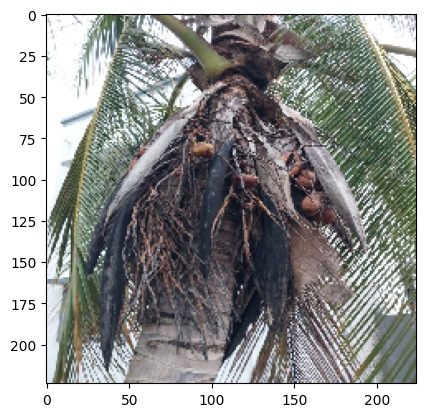

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
File: BudRootDropping002.jpg
Predicted class: 3
Predictions: [[4.4330567e-02 1.6101461e-08 2.2020403e-01 7.3546541e-01 2.5531313e-10]]


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
# Load the trained model
model = tf.keras.models.load_model("model.keras")

# Fungsi untuk memprediksi gambar baru
def predict_new_image(image_path, model):
    # Load dan pra-pemrosesan gambar baru
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi gambar

    # Lakukan prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class, predictions

# Mengunggah dan memprediksi gambar baru
uploaded = files.upload()

for fn in uploaded.keys():
    # Menampilkan gambar
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    imgplot = plt.imshow(img)
    plt.show()

    # Prediksi gambar
    predicted_class, predictions = predict_new_image(path, model)
    print(f"File: {fn}")
    print(f"Predicted class: {predicted_class[0]}")
    print(f"Predictions: {predictions}")


In [ ]:
#Cek Shape Model
output_shape = model.output_shape
print("Output shape:", output_shape)

Output shape: (None, 5)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to the image you want to make predictions on
image_path = '/content/drive/MyDrive/bud.png'

# Load the image and resize it to match the input shape of the model
img = image.load_img(image_path, target_size=(224, 224))

# Convert the image to an array
img_array = image.img_to_array(img)

# Expand the dimensions of the image so that it matches the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (normalize pixel values)
img_array = img_array / 255.0

# Make predictions
predictions = model.predict(img_array)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class = class_folders[predicted_class_index]  # Assuming class_folders is a list of class names

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted class: Leaf Rot


### Evaluasi Model

In [ ]:
#Evaluating Model
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 835ms/step - loss: 0.1064 - sparse_categorical_accuracy: 0.9812
Validation Loss: 0.12585976719856262
Validation Accuracy: 0.9789999723434448


In [ ]:
#Classification Report
from sklearn.metrics import classification_report
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
print(classification_report(y_true, y_pred_classes))

125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 827ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.98      0.98      0.98       400
           2       0.96      0.95      0.96       400
           3       0.96      0.96      0.96       400
           4       1.00      1.00      1.00       400

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
def plot_precision_recall_curve(y_true, y_pred, num_classes):
    precision = [precision_score(y_true, y_pred, average='micro')]
    recall = [recall_score(y_true, y_pred, average='micro')]

    for class_idx in range(num_classes):
        precision.append(precision_score(y_true == class_idx, y_pred == class_idx))
        recall.append(recall_score(y_true == class_idx, y_pred == class_idx))

    plt.figure(figsize=(12, 6))
    plt.bar(range(num_classes + 1), precision, color='blue', alpha=0.7, label='Precision')
    plt.bar(range(num_classes + 1), recall, color='green', alpha=0.7, label='Recall')
    plt.xticks(range(num_classes + 1), ['Overall'] + class_folders, rotation=45)

### Import Model

In [ ]:
# Simpan model ke dalam file HDF5
model.save('model.h5')

# Buat file zip
with zipfile.ZipFile('model.zip', 'w') as zipf:
    zipf.write('model.h5')


In [ ]:
# Simpan model ke dalam format .keras
model.save("model.keras")

# Simpan konfigurasi model ke dalam file config.json
config = model.get_config()
with open("config.json", "w") as json_file:
    json.dump(config, json_file)

# Simpan label class ke dalam file labels.txt (opsional)
class_labels = train_data.class_indices
with open("labels.txt", "w") as labels_file:
    labels_file.write("\n".join(class_labels.keys()))

# Buat file ZIP dan tambahkan model, konfigurasi, dan file lainnya
with zipfile.ZipFile("model.zip", "w") as zipf:
    zipf.write("model.keras")
    zipf.write("config.json")
    zipf.write("labels.txt")

